# Non merging inputs

TODO:
 - [X] Is it better with full or the balanced dataset? -> Non balanced (even better when excluding non-coherent data)
 - [X] Try conformal with the decade -> Too few classes, argmax is way better

In [1]:
import os
# cuda_visible_devices = 0,1,2,3
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

import pandas as pd

import numpy as np
from tabulate import tabulate
import seaborn as sns
from tqdm import tqdm

import nltk
from nltk import WordPunctTokenizer
from nltk import TreebankWordTokenizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords

import stanza
stanza.download('en')


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch

from tabulate import tabulate

RANDOM_SEED = 42

[nltk_data] Downloading package punkt to /home/alocaputo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/alocaputo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alocaputo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alocaputo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/data01/alocaputo/miniconda3/envs/icdar2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-26 08:50:18 INFO: Downloaded file to /home/alocaputo/stanza_resources/resources.json
2025-03-26 08:50:18 INFO: Downloading default packages for language: en (Engl

## Data Loading

In [2]:
texts_path = './data/Task2/texts'

train_path = os.path.join(texts_path, 'train')
valid_path = os.path.join(texts_path, 'valid')

train_files = os.listdir(train_path)
valid_files = os.listdir(valid_path)

f"Train: {len(train_files)}, Test: {len(valid_files)}"

label2century = {1: '17th century', 2: '18th century', 3: '19th century', 4: '20th century', 5: '21st century'}

train21 = pd.read_csv('./data/Task2/task2.1/train.csv')
valid21 = pd.read_csv('./data/Task2/task2.1/valid.csv')

train22 = pd.read_csv('./data/Task2/task2.2/train.csv')
valid22 = pd.read_csv('./data/Task2/task2.2/valid.csv')

train21.rename(columns={'label': 'century'}, inplace=True)
train21['file_name'] = train21['id']
train21['id'] = train21.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train21.set_index('id', inplace=True)

valid21.rename(columns={'label': 'century'}, inplace=True)
valid21['file_name'] = valid21['id']
valid21['id'] = valid21.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid21.set_index('id', inplace=True)

In [3]:
train22 = pd.read_csv('./data/Task2/task2.2/train.csv')
valid22 = pd.read_csv('./data/Task2/task2.2/valid.csv')

train22.rename(columns={'label': 'decade'}, inplace=True)
train22['file_name'] = train22['id']
train22['id'] = train22.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train22.set_index('id', inplace=True)

valid22.rename(columns={'label': 'decade'}, inplace=True)
valid22['file_name'] = valid22['id']
valid22['id'] = valid22.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid22.set_index('id', inplace=True)

In [4]:
import pickle
with open('blacklist.pkl', 'rb') as f:
    blacklist = pickle.load(f)

blacklist_train = blacklist['train']
blacklist_valid = blacklist['valid']

In [5]:
def decade2year(deca):
    return ((deca // 10) + 16) * 100 + ((deca % 10)) * 10

def year2cd(year):
    return ((year // 100 - 16) * 10  + (year - (year // 100)*100)//10)

In [6]:
import ftfy

def get_clean_text(path):
    
    with open(path, 'rb') as infile:
        txt_ry = infile.read()
    misdecoded_text = txt_ry.decode("utf-8", errors="ignore")

    return ftfy.fix_text(misdecoded_text)

In [7]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, file_names, labels, path, clear=False):
        self.file_names = file_names
        self.labels = labels
        self.path = path
        self.clear = clear

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        if self.clear:
            text = get_clean_text(os.path.join(self.path, file_name))
        else:
            with open(os.path.join(self.path, file_name), 'r') as file:
                text = file.read()

        return text, self.labels[idx]

In [8]:
X_train_21 = []
y_train_21 = []

X_valid_21 = []
y_valid_21 = []

for idx, row in train21.iterrows():
    file_name = row.file_name
    century = row.century
    X_train_21.append(file_name)
    y_train_21.append(century-1)

for idx, row in valid21.iterrows():
    file_name = row.file_name
    century = row.century
    X_valid_21.append(file_name)
    y_valid_21.append(century-1)

In [9]:
np.random.seed(RANDOM_SEED)

X_train_21_eq = []
y_train_21_eq = []
for i in range(1, 6):
    x = train21[train21['century'] == i].sample(1834)
    X_train_21_eq.extend(x['file_name'])
    y_train_21_eq.extend(x['century']-1)

X_valid_21_eq = []
y_valid_21_eq = []
for i in range(1, 6):
    x = valid21[valid21['century'] == i].sample(457)
    X_valid_21_eq.extend(x['file_name'])
    y_valid_21_eq.extend(x['century']-1)

In [10]:
X_train_22 = []
y_train_22 = []

X_valid_22 = []
y_valid_22 = []

for idx, row in train22.iterrows():
    file_name = row.file_name
    decade = row.decade
    X_train_22.append(file_name)
    y_train_22.append(decade-1)

for idx, row in valid22.iterrows():
    file_name = row.file_name
    decade = row.decade
    X_valid_22.append(file_name)
    y_valid_22.append(decade-1)

In [11]:
X_train_22_eq = []
y_train_22_eq = []
for x in tqdm(X_train_21_eq):
    row = train22[train22['file_name'] == x]
    decade = int(row.decade)
    X_train_22_eq.append(x)
    y_train_22_eq.append(decade)
    
X_valid_22_eq = []
y_valid_22_eq = []
for x in X_valid_21_eq:
    row = valid22[valid22['file_name'] == x]
    decade = int(row.decade)
    X_valid_22_eq.append(x)
    y_valid_22_eq.append(decade)

  0%|                                                                                                                                                                                        | 0/9170 [00:00<?, ?it/s]/tmp/ipykernel_2953525/2300074627.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  decade = int(row.decade)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9170/9170 [02:16<00:00, 67.30it/s]
/tmp/ipykernel_2953525/2300074627.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  decade = int(row.decade)


In [12]:
train21_dataset = TextDataset(X_train_21, y_train_21, train_path)
valid21_dataset = TextDataset(X_valid_21, y_valid_21, valid_path)

batch_size = 16
train21_dataloader = DataLoader(train21_dataset, batch_size=batch_size, shuffle=True)
valid21_dataloader = DataLoader(valid21_dataset, batch_size=batch_size, shuffle=False)

train21_eq_dataset = TextDataset(X_train_21_eq, y_train_21_eq, train_path)
valid21_eq_dataset = TextDataset(X_valid_21_eq, y_valid_21_eq, valid_path)

batch_size = 16
train21_eq_dataloader = DataLoader(train21_eq_dataset, batch_size=batch_size, shuffle=True)
valid21_eq_dataloader = DataLoader(valid21_eq_dataset, batch_size=batch_size, shuffle=False)

train22_dataset = TextDataset(X_train_22, y_train_22, train_path)
valid22_dataset = TextDataset(X_valid_22, y_valid_22, valid_path)

batch_size = 16
train22_dataloader = DataLoader(train22_dataset, batch_size=batch_size, shuffle=True)
valid22_dataloader = DataLoader(valid22_dataset, batch_size=batch_size, shuffle=False)

train22_eq_dataset = TextDataset(X_train_22_eq, y_train_22_eq, train_path)
valid22_eq_dataset = TextDataset(X_valid_22_eq, y_valid_22_eq, valid_path)

batch_size = 16
train22_eq_dataloader = DataLoader(train22_eq_dataset, batch_size=batch_size, shuffle=True)
valid22_eq_dataloader = DataLoader(valid22_eq_dataset, batch_size=batch_size, shuffle=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204708/204708 [10:16<00:00, 332.07it/s]


Token Length Statistics:
- Maximum: 9481
- Mean: 1395.41
- Median: 1325.00
- 95th percentile: 1876.00
- 99th percentile: 2235.00


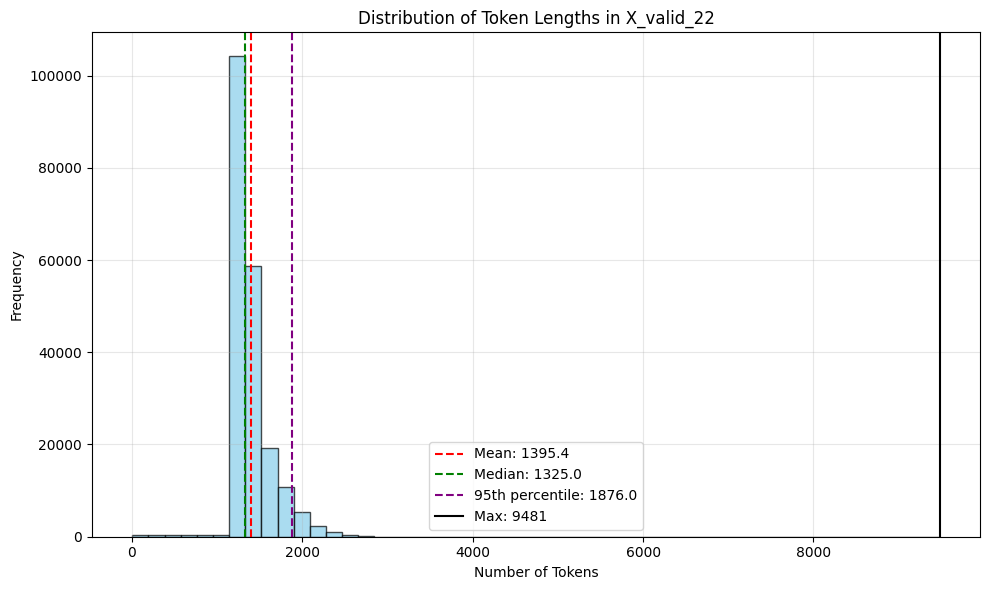

In [169]:
token_lengths = []
for text, _ in tqdm(train21_dataset):
    tokens = tokenizer(text, add_special_tokens=True, return_tensors="pt")
    token_lengths.append(tokens['input_ids'].shape[1])

# Calculate statistics
max_length = max(token_lengths)
mean_length = np.mean(token_lengths)
median_length = np.median(token_lengths)
p95_length = np.percentile(token_lengths, 95)
p99_length = np.percentile(token_lengths, 99)

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.1f}')
plt.axvline(x=median_length, color='green', linestyle='--', label=f'Median: {median_length:.1f}')
plt.axvline(x=p95_length, color='purple', linestyle='--', label=f'95th percentile: {p95_length:.1f}')
plt.axvline(x=max_length, color='black', linestyle='-', label=f'Max: {max_length}')

plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

print(f"Token Length Statistics:")
print(f"- Maximum: {max_length}")
print(f"- Mean: {mean_length:.2f}")
print(f"- Median: {median_length:.2f}")
print(f"- 95th percentile: {p95_length:.2f}")
print(f"- 99th percentile: {p99_length:.2f}")

In [ ]:
_train_22

In [192]:
cg = 0
cg_list = []
cg_labels = []
for idx, file_name in tqdm(enumerate(X_train_21), total=len(X_train_21)):
    
    tidx = int(file_name.replace('train_text', '').replace('.txt', ''))
    if tidx in blacklist_valid:
        continue
    with open(os.path.join(train_path, file_name), 'r') as file:
        text = file.read()
    
    if 'gutenberg' in text.lower():
        cg += 1
        cg_list.append(text)
        cg_labels.append(y_train_21[idx])
print(cg)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204708/204708 [00:12<00:00, 16872.76it/s]

2128


In [193]:
Counter(cg_labels)

Counter({2: 1736, 3: 181, 1: 117, 0: 75, 4: 19})

In [181]:
for cgl in cg_list[:20]:
    print(cgl)
    print()

you do or cause to occur: (a) distribution of this or any Project Gutenberg-tm work, (b) alteration, modification, or additions or deletions to any Project Gutenberg-tm work, and (c) any Defect you cause. Section 2. Information about the Mission of Project Gutenberg-tm Project Gutenberg-tm is synonymous with the free distribution of electronic works in formats readable by the widest variety of computers including obsolete, old, middle-aged and new computers. It exists because of the efforts of hundreds of volunteers and donations from people in all walks of life. Volunteers and financial support to provide volunteers with the assistance they need, is critical to reaching Project Gutenberg-tm's goals and ensuring that the Project Gutenberg-tm collection will remain freely available for generations to come. In 2001, the Project Gutenberg Literary Archive Foundation was created to provide a secure and permanent future for Project Gutenberg-tm and future generations. To learn more about th

In [13]:
def mean_avg_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

## Century classifier

In [131]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CenturyClassifier(nn.Module):
    def __init__(self, longformer, num_classes):
        super(CenturyClassifier, self).__init__()
        self.bert = longformer
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(longformer.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [132]:
def train_century_classifier(model, tokenizer, train_dataloader, n_epochs=3):
    
    model_century_classifier = CenturyClassifier(model, 5)
    model_century_classifier.to(device)
    
    optimizer = optim.Adam(model_century_classifier.parameters(), lr=1e-5)
    criterion = nn.CrossEntropyLoss()
    
    model_century_classifier.train()
    
    for epoch in range(n_epochs):
        for text, labels in tqdm(train_dataloader):
            optimizer.zero_grad()
            tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512,).to(device)
            labels = torch.tensor(labels).to(device)
            output = model_century_classifier(**tokens)
            loss = criterion(output.view(-1, 5), labels.view(-1))
            loss.backward()
            optimizer.step()
        print("Epoch:", epoch, "Loss:", loss.item())
    
    return model_century_classifier

In [135]:
tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
model = AutoModel.from_pretrained("allenai/longformer-base-4096")

# Balanced dataset
model_century_classifier_eq = train_century_classifier(model, tokenizer, train21_eq_dataloader)

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
model = AutoModel.from_pretrained("allenai/longformer-base-4096")

# Full dataset
model_century_classifier = train_century_classifier(model, tokenizer, train21_dataloader)

  0%|                                                                                                                                                                                         | 0/574 [00:00<?, ?it/s]/tmp/ipykernel_518077/2369404271.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 574/574 [05:59<00:00,  1.60it/s]


Epoch: 0 Loss: 1.28499174118042


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 574/574 [05:59<00:00,  1.60it/s]


Epoch: 1 Loss: 1.2889608144760132


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 574/574 [05:59<00:00,  1.60it/s]

Epoch: 2 Loss: 0.39171406626701355


### Standard

In [138]:
model_century_classifier_eq.eval()
y_pred_21_eq = []
y_true_21_eq = []

with torch.no_grad():
    for text, labels in tqdm(valid21_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512,).to(device)
        output = model_century_classifier_eq(**tokens)
        predictions = output.argmax(dim=1)
        y_pred_21_eq.extend(predictions.detach().cpu().numpy())
        y_true_21_eq.extend(labels.cpu().numpy())
        
print(f"MAE: {mean_avg_error(np.array(y_true_21_eq), np.array(y_pred_21_eq))}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3416/3416 [10:19<00:00,  5.52it/s]

MAE: 0.9219959378602405


In [49]:
model_century_classifier.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for text, labels in tqdm(valid21_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512,).to(device)
        output = model_decade_classifier(**tokens)
        predictions = output.argmax(dim=1)
        y_pred.extend(predictions.detach().cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        
print(f"MAE: {mean_avg_error(np.array(y_true), np.array(y_pred))}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3416/3416 [10:24<00:00,  5.47it/s]

MAE: 2.0821210956798595


### Conformal Prediction

In [141]:
from sklearn.model_selection import train_test_split


X_calib_21_eq, X_test_21_eq, y_calib_21_eq, y_test_21_eq = train_test_split(
    X_valid_21_eq, y_valid_21_eq, test_size=0.5, random_state=RANDOM_SEED
)

calib_21_eq_dataset = TextDataset(X_calib_21_eq, y_calib_21_eq, valid_path)
test_21_eq_dataset = TextDataset(X_test_21_eq, y_test_21_eq, valid_path)
calib_21_eq_dataloader = DataLoader(calib_21_eq_dataset, batch_size=16, shuffle=False)
test_21_eq_dataloader = DataLoader(test_21_eq_dataset, batch_size=16, shuffle=False)

In [142]:
X_calib_21, X_test_21, y_calib_21, y_test_21 = train_test_split(
    X_valid_21, y_valid_21, test_size=0.5, random_state=RANDOM_SEED
)

calib_21_dataset = TextDataset(X_calib_21, y_calib_21, valid_path)
test_21_dataset = TextDataset(X_test_21, y_test_21, valid_path)
calib_21_dataloader = DataLoader(calib_21_dataset, batch_size=16, shuffle=False)
test_21_dataloader = DataLoader(test_21_dataset, batch_size=16, shuffle=False)

In [153]:
# Calibration
calib_21_probs = []
calib_21_preds = []
calib_21_true = []

model_century_classifier_eq.eval()

with torch.no_grad():
    for text, labels in tqdm(calib_21_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512).to(device)
        output = model_century_classifier_eq(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        calib_21_probs.extend(probabilities.detach().cpu().numpy())
        calib_21_preds.extend(predictions.detach().cpu().numpy())
        calib_21_true.extend(labels.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [05:09<00:00,  5.52it/s]


In [156]:
# Group calibration data by true class
class_nonconformity_21 = {class_idx: [] for class_idx in range(5)}

# Compute class-specific nonconformity scores
for i, (prob, true_label) in enumerate(zip(calib_21_probs, calib_21_true)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_21[true_label].append(nonconformity)

# Calculate threshold for each class
class_thresholds_21 = {}
confidence_level = 0.90
alpha = 1 - confidence_level

n_samples = len(calib_21_true)
for class_idx, scores in class_nonconformity_21.items():
    q = np.ceil((n_samples + 1) * (1 - alpha)) / n_samples # corrected formula
    class_thresholds_21[class_idx] = np.quantile(scores, q)        

In [157]:
test_preds_21 = []
test_intervals_21 = []
test_true_21 = []
test_probs_21 = []

with torch.no_grad():
    for text, labels in tqdm(test_21_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512).to(device)
        output = model_century_classifier_eq(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        for i, prob in enumerate(probabilities):
            pred = predictions[i].item()
            true_label = labels[i].item()          
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(5):
                # Use threshold specific to the candidate class
                if 1 - prob[label].item() <= class_thresholds_21[label]:
                    prediction_set.append(label)  
                    
            test_preds_21.append(pred)
            test_intervals_21.append(prediction_set)
            test_true_21.append(true_label)
            test_probs_21.append(prob.detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [05:11<00:00,  5.48it/s]


In [159]:
test_preds_argmax_21 = []
test_preds_var_21 = []
test_preds_var_rel_21 = []

test_true_var_21 = []
thslds_21 = [ 1 - x for x in class_thresholds_21.values()]

for idx in range(len(test_probs_21)):
    intervals = test_intervals_21[idx]
    #if len(intervals) != 1:
    #    continue
    true_label = test_true_21[idx]
    probs = test_probs_21[idx]
    
    exeeding_idx = np.zeros(5)
    exeeding_rel_idx = np.zeros(5)
    
    for interval in intervals:
        if probs[interval] > thslds_21[interval]:
            
            exeeding_idx[interval] = abs(probs[interval]-thslds_21[interval])
            
            exeeding_rel_idx[interval] = abs(probs[interval]-thslds_21[interval]) / thslds_21[interval] #probs[interval]
            
    test_preds_argmax_21.append(np.argmax(probs))
    test_preds_var_21.append(np.argmax(exeeding_idx))
    test_preds_var_rel_21.append(np.argmax(exeeding_rel_idx))
    test_true_var_21.append(true_label)
    
print(f"argmax (MAE): {mean_avg_error(np.array(test_true_var_21), np.array(test_preds_argmax_21))}")
print(f"variance (MAE): {mean_avg_error(np.array(test_true_var_21), np.array(test_preds_var_21))}")
print(f"variance rel (MAE): {mean_avg_error(np.array(test_true_var_21), np.array(test_preds_var_rel_21))}")

argmax (MAE): 0.9223450193954476
variance (MAE): 0.9301763887872356
variance rel (MAE): 1.0139793603161824


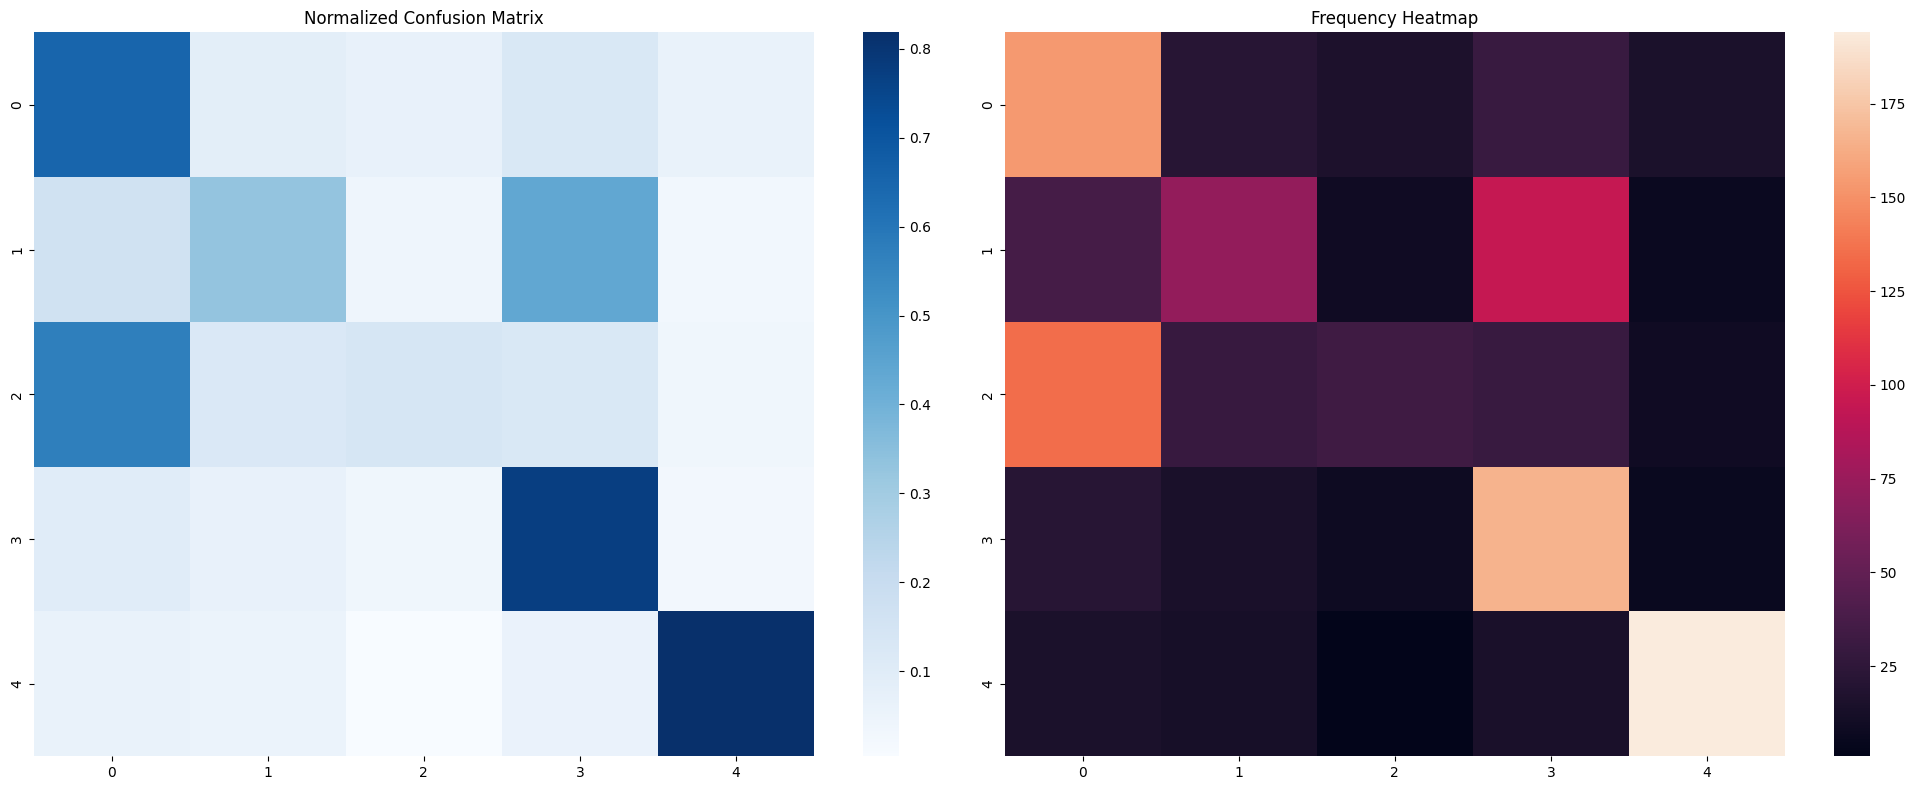

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

tick_positions = np.arange(5)

cm = confusion_matrix(y_test_true, y_test_pred, labels=np.arange(5))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, cmap='Blues', ax=ax1)

ax1.set_xticks(tick_positions + 0.5)
ax1.set_xticklabels(tick_positions)
ax1.set_title('Normalized Confusion Matrix')


freq3 = np.zeros((5,5))
for b, c in zip(y_test_true, y_test_pred):
    freq3[b,c] += 1

sns.heatmap(freq3, cmap='rocket', ax=ax2)

ax2.set_xticks(tick_positions + 0.5)
ax2.set_xticklabels(tick_positions)
ax2.set_title('Frequency Heatmap')

plt.tight_layout()
plt.show()

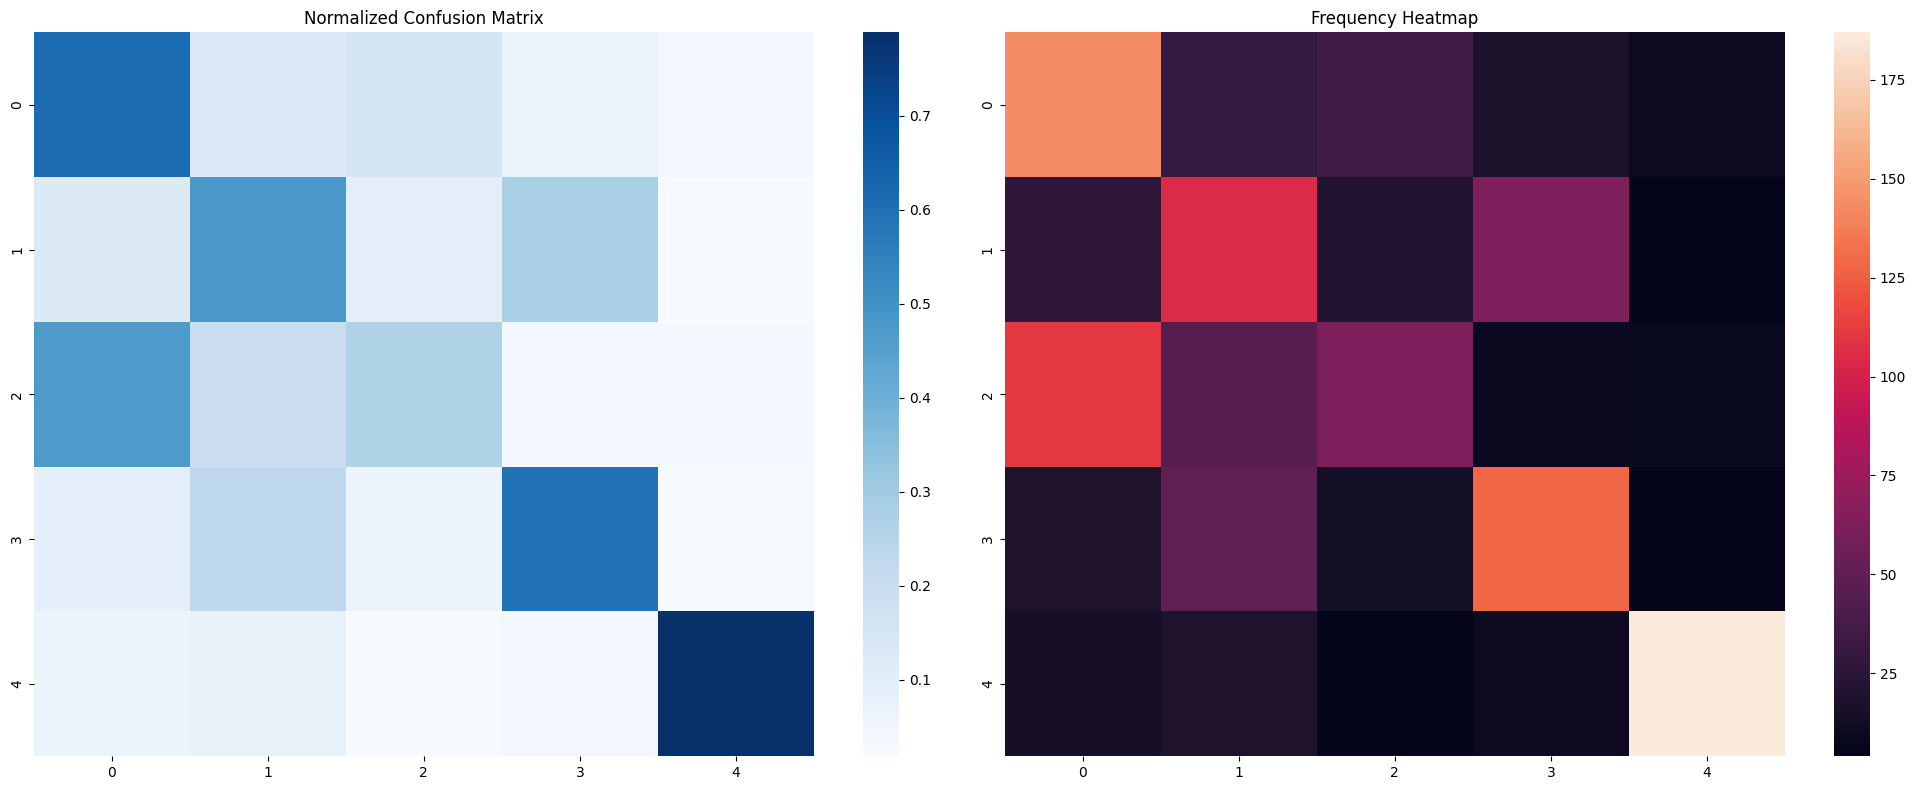

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

tick_positions = np.arange(5)

cm = confusion_matrix(test_true_var, test_preds_var_rel, labels=np.arange(5))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, cmap='Blues', ax=ax1)

ax1.set_xticks(tick_positions + 0.5)
ax1.set_xticklabels(tick_positions)
ax1.set_title('Normalized Confusion Matrix')


freq3 = np.zeros((5,5))
for b, c in zip(test_true_var, test_preds_var_rel):
    freq3[b,c] += 1

sns.heatmap(freq3, cmap='rocket', ax=ax2)

ax2.set_xticks(tick_positions + 0.5)
ax2.set_xticklabels(tick_positions)
ax2.set_title('Frequency Heatmap')

for dec_line in range(10,50,10):
    ax1.axvline(dec_line, color='red')
    ax1.axhline(dec_line, color='red')
    ax2.axvline(dec_line, color='red')
    ax2.axhline(dec_line, color='red')

plt.tight_layout()
plt.show()

In [48]:
y_test_pred_all = []
y_test_true_all = []

with torch.no_grad():
    for text, labels in tqdm(valid21_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512,).to(device)
        output = model_century_classifier(**tokens)
        predictions = output.argmax(dim=1)
        y_test_pred_all.extend(predictions.detach().cpu().numpy())
        y_test_true_all.extend(labels.cpu().numpy())
        
print(f"MAE (without CP) [All]: {mean_avg_error(np.array(y_test_true_all), np.array(y_test_pred_all))}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3416/3416 [10:18<00:00,  5.52it/s]

MAE (without CP) [All]: 1.3576329801833453


In [50]:
# Calibration
calib_probs_all = []
calib_preds_all = []
calib_true_all = []

model_century_classifier.eval()

with torch.no_grad():
    for text, labels in tqdm(calib_all_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512).to(device)
        output = model_century_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        calib_probs_all.extend(probabilities.detach().cpu().numpy())
        calib_preds_all.extend(predictions.detach().cpu().numpy())
        calib_true_all.extend(labels.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [05:11<00:00,  5.48it/s]


In [51]:
# Group calibration data by true class
class_nonconformity_all = {class_idx: [] for class_idx in range(5)}

# Compute class-specific nonconformity scores
for i, (prob, true_label) in enumerate(zip(calib_probs_all, calib_true_all)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_all[true_label].append(nonconformity)

# Calculate threshold for each class
class_thresholds_all = {}
confidence_level = 0.90
alpha = 1 - confidence_level

n_samples = len(calib_true_all)
for class_idx, scores in class_nonconformity_all.items():
    # class_thresholds_longformer2[class_idx] = np.quantile(scores, 1 - alpha)
    if len(scores) > 0:
        q = np.ceil((n_samples + 1) * (1 - alpha)) / n_samples # corrected formula
        class_thresholds_all[class_idx] = np.quantile(scores, q)
    else:
        class_thresholds_all[class_idx] = threshold
        

In [52]:
test_preds_all = []
test_intervals_all = []
test_true_all = []
test_probs_all = []

with torch.no_grad():
    for text, labels in tqdm(valid21_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512).to(device)
        output = model_century_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        for i, prob in enumerate(probabilities): # Iterate on the batch
            pred = predictions[i].item()
            true_label = labels[i].item()          
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(5):
                # Use threshold specific to the candidate class
                if 1 - prob[label].item() <= class_thresholds[label]:
                    prediction_set.append(label)  
                    
            test_preds_all.append(pred)
            test_intervals_all.append(prediction_set)
            test_true_all.append(true_label)
            test_probs_all.append(prob.detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3416/3416 [10:27<00:00,  5.44it/s]


In [53]:
test_preds_argmax = []
test_preds_var = []
test_preds_var_rel = []

test_true_var = []
thslds = [ 1 - x for x in class_thresholds.values()]

for idx in range(len(test_probs)):
    intervals = test_intervals[idx]
    #if len(intervals) != 1:
    #    continue
    true_label = test_true[idx]
    probs = test_probs[idx]
    
    exeeding_idx = np.zeros(5)
    exeeding_rel_idx = np.zeros(5)
    
    for interval in intervals:
        if probs[interval] > thslds[interval]:
            
            exeeding_idx[interval] = abs(probs[interval]-thslds[interval])
            
            exeeding_rel_idx[interval] = abs(probs[interval]-thslds[interval]) / thslds[interval] #probs[interval]
            
    test_preds_argmax.append(np.argmax(probs))
    test_preds_var.append(np.argmax(exeeding_idx))
    test_preds_var_rel.append(np.argmax(exeeding_rel_idx))
    test_true_var.append(true_label)
    
print(f"argmax (MAE) [All]: {mean_avg_error(np.array(test_true_var), np.array(test_preds_argmax))}")
print(f"variance (MAE) [All]: {mean_avg_error(np.array(test_true_var), np.array(test_preds_var))}")
print(f"variance rel (MAE) [All]: {mean_avg_error(np.array(test_true_var), np.array(test_preds_var_rel))}")

argmax (MAE) [All]: 0.849890590809628
variance (MAE) [All]: 0.8512035010940919
variance rel (MAE) [All]: 0.8183807439824945


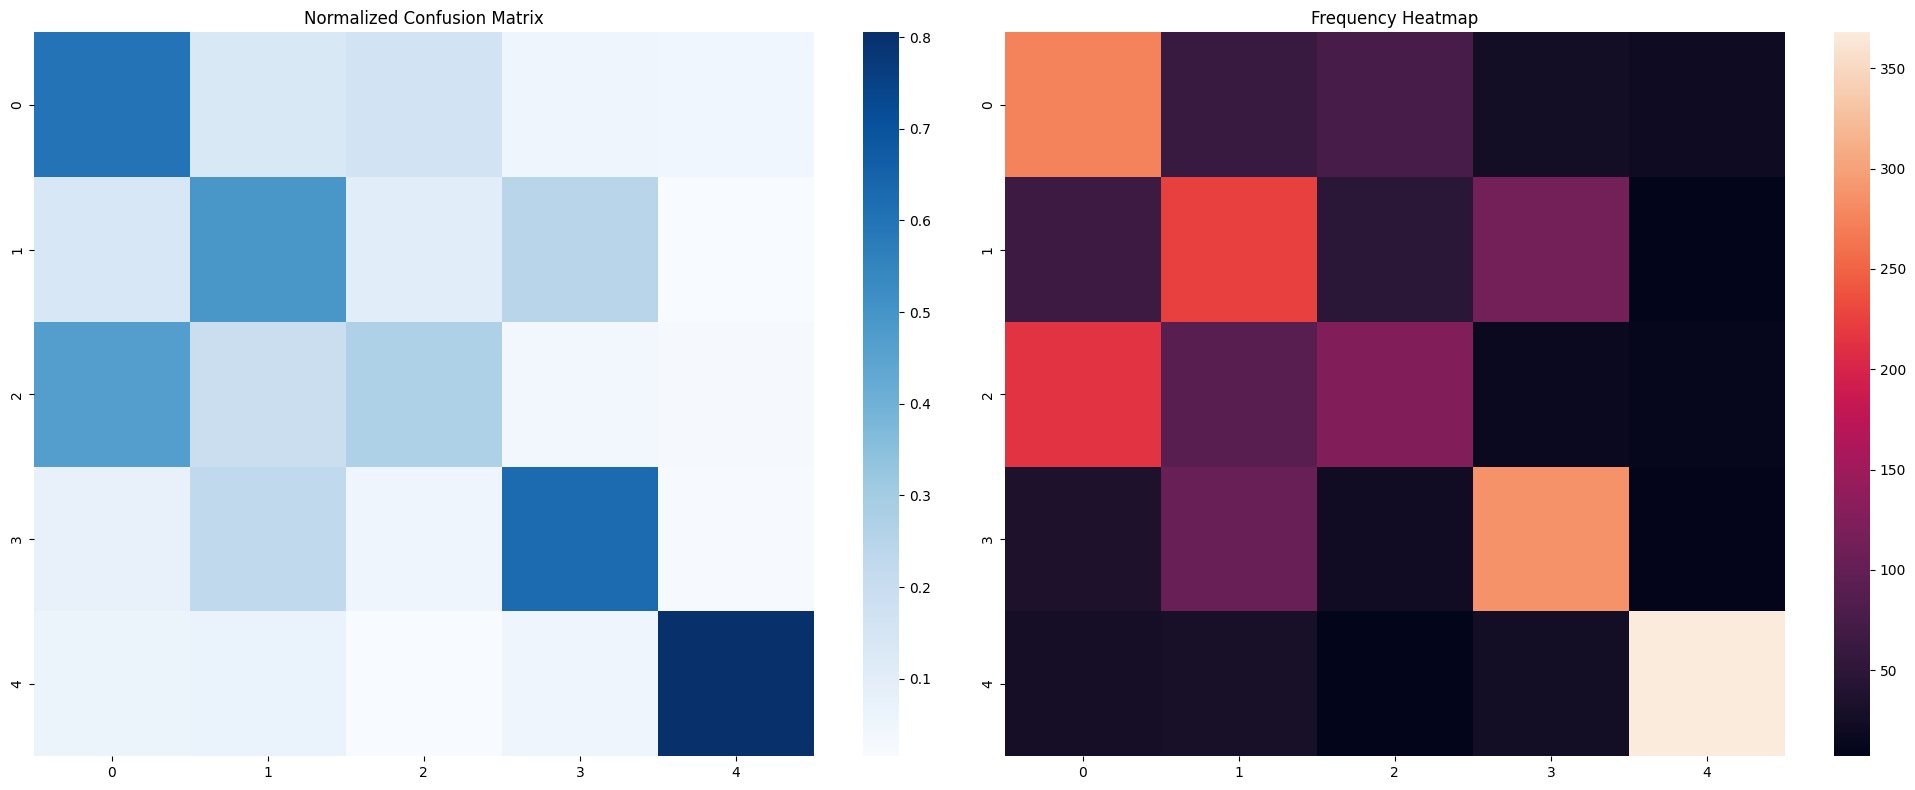

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

tick_positions = np.arange(5)

cm = confusion_matrix(test_true_var, test_preds_var_rel, labels=np.arange(5))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, cmap='Blues', ax=ax1)

ax1.set_xticks(tick_positions + 0.5)
ax1.set_xticklabels(tick_positions)
ax1.set_title('Normalized Confusion Matrix')


freq3 = np.zeros((5,5))
for b, c in zip(test_true_var, test_preds_var_rel):
    freq3[b,c] += 1

sns.heatmap(freq3, cmap='rocket', ax=ax2)

ax2.set_xticks(tick_positions + 0.5)
ax2.set_xticklabels(tick_positions)
ax2.set_title('Frequency Heatmap')

for dec_line in range(10,50,10):
    ax1.axvline(dec_line, color='red')
    ax1.axhline(dec_line, color='red')
    ax2.axvline(dec_line, color='red')
    ax2.axhline(dec_line, color='red')

plt.tight_layout()
plt.show()

### Evaluation

In [49]:
def plot_confusion_matrix(y_true, y_pred, n_classes=5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    tick_positions = np.arange(n_classes)

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm, cmap='Blues', ax=ax1)

    ax1.set_xticks(tick_positions + 0.5)
    ax1.set_xticklabels(tick_positions)
    ax1.set_title('Normalized Confusion Matrix')


    freq3 = np.zeros((n_classes,n_classes))
    for b, c in zip(y_true, y_pred):
        freq3[b,c] += 1

    sns.heatmap(freq3, cmap='rocket', ax=ax2, vmin=10, vmax=1000)

    ax2.set_xticks(tick_positions + 0.5)
    ax2.set_xticklabels(tick_positions)
    ax2.set_title('Frequency Heatmap')

    for dec_line in range(10,50,10):
        ax1.axvline(dec_line, color='red')
        ax1.axhline(dec_line, color='red')
        ax2.axvline(dec_line, color='red')
        ax2.axhline(dec_line, color='red')

    plt.tight_layout()
    plt.show()

In [14]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
model = AutoModel.from_pretrained("allenai/longformer-base-4096")

class CenturyClassifier(nn.Module):
    def __init__(self, longformer, num_classes):
        super(CenturyClassifier, self).__init__()
        self.bert = longformer
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(longformer.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [15]:
model_century_classifier = CenturyClassifier(model, 5)
model_century_classifier.load_state_dict(torch.load('models/task21/century_classifier_weights_3.pt'))
model_century_classifier.to(device)
model_century_classifier.eval()

model_century_classifier_equal = CenturyClassifier(model, 5)
model_century_classifier_equal.load_state_dict(torch.load('models/task21/century_classifier_weights_3_equal.pt'))
model_century_classifier_equal.to(device)
model_century_classifier_equal.eval()

model_century_classifier_blacklist = CenturyClassifier(model, 5)
model_century_classifier_blacklist.load_state_dict(torch.load('models/task21/century_classifier_weights_3_blacklist.pt'))
model_century_classifier_blacklist.to(device)
model_century_classifier_blacklist.eval()

model_century_classifier_equal_blacklist = CenturyClassifier(model, 5)
model_century_classifier_equal_blacklist.load_state_dict(torch.load('models/task21/century_classifier_weights_3_equal_blacklist.pt'))
model_century_classifier_equal_blacklist.to(device)
model_century_classifier_equal_blacklist.eval()
print("Loaded")

Loaded


#### Standard

In [20]:
## Run 

## CUDA_VISIBLE_DEVICES={ID} python3 eval_task21.py [--equal] [--blacklist]

In [51]:
# Load results

with open('results/task21/full/century_classifier_weights_3.pkl', 'rb') as f:
    mcc = pickle.load(f)
    
with open('results/task21/full/century_classifier_weights_3_equal.pkl', 'rb') as f:
    mcce = pickle.load(f)
    
with open('results/task21/full/century_classifier_weights_3_blacklist.pkl', 'rb') as f:
    mccb = pickle.load(f)
    
with open('results/task21/full/century_classifier_weights_3_equal_blacklist.pkl', 'rb') as f:
    mcceb = pickle.load(f)
    
    
with open('results/task21/blacklist/century_classifier_weights_3.pkl', 'rb') as f:
    bmcc = pickle.load(f)
    
with open('results/task21/blacklist/century_classifier_weights_3_equal.pkl', 'rb') as f:
    bmcce = pickle.load(f)
    
with open('results/task21/blacklist/century_classifier_weights_3_blacklist.pkl', 'rb') as f:
    bmccb = pickle.load(f)
    
with open('results/task21/blacklist/century_classifier_weights_3_equal_blacklist.pkl', 'rb') as f:
    bmcceb = pickle.load(f)

In [62]:
def compute_class_mae(y_true, y_pred, n_classes=5):
    class_maes = []
    for i in range(n_classes):
        indices = [idx for idx, label in enumerate(y_true) if label == i]
        if indices:
            class_mae = mean_avg_error(np.array([y_true[idx] for idx in indices]), 
                                        np.array([y_pred[idx] for idx in indices]))
            class_maes.append(class_mae)
        else:
            class_maes.append(float('nan'))
    return class_maes

def count_class_frequencies(y_true, n_classes=5):
    frequencies = [0] * n_classes
    for label in y_true:
        frequencies[label] += 1
    return frequencies

In [63]:
table_data = []

# Base model
overall_mae_base = mean_avg_error(np.array(mcc['true_labels']), np.array(mcc['predictions']))
class_maes_base = compute_class_mae(mcc['true_labels'], mcc['predictions'])
class_freqs_base = count_class_frequencies(mcc['true_labels'])
base_row = ["Base", f"{overall_mae_base:.4f} [{len(mcc['true_labels'])}]"]
for i, mae in enumerate(class_maes_base):
    base_row.append(f"{mae:.4f} [{class_freqs_base[i]}]")
table_data.append(base_row)

# Equal model
overall_mae_equal = mean_avg_error(np.array(mcce['true_labels']), np.array(mcce['predictions']))
class_maes_equal = compute_class_mae(mcce['true_labels'], mcce['predictions'])
class_freqs_equal = count_class_frequencies(mcce['true_labels'])
equal_row = ["Equal", f"{overall_mae_equal:.4f} [{len(mcce['true_labels'])}]"]
for i, mae in enumerate(class_maes_equal):
    equal_row.append(f"{mae:.4f} [{class_freqs_equal[i]}]")
table_data.append(equal_row)

# Blacklist model
overall_mae_blacklist = mean_avg_error(np.array(mccb['true_labels']), np.array(mccb['predictions']))
class_maes_blacklist = compute_class_mae(mccb['true_labels'], mccb['predictions'])
class_freqs_blacklist = count_class_frequencies(mccb['true_labels'])
blacklist_row = ["Blacklist", f"{overall_mae_blacklist:.4f} [{len(mccb['true_labels'])}]"]
for i, mae in enumerate(class_maes_blacklist):
    blacklist_row.append(f"{mae:.4f} [{class_freqs_blacklist[i]}]")
table_data.append(blacklist_row)

# Equal-Blacklist model
overall_mae_equal_blacklist = mean_avg_error(np.array(mcceb['true_labels']), np.array(mcceb['predictions']))
class_maes_equal_blacklist = compute_class_mae(mcceb['true_labels'], mcceb['predictions'])
class_freqs_equal_blacklist = count_class_frequencies(mcceb['true_labels'])
equal_blacklist_row = ["Equal-Blacklist", f"{overall_mae_equal_blacklist:.4f} [{len(mcceb['true_labels'])}]"]
for i, mae in enumerate(class_maes_equal_blacklist):
    equal_blacklist_row.append(f"{mae:.4f} [{class_freqs_equal_blacklist[i]}]")
table_data.append(equal_blacklist_row)

print(tabulate(table_data,
               ["Model", "Overall MAE", "Century 0", "Century 1", "Century 2", "Century 3", "Century 4"], 
               tablefmt="grid"))

+-----------------+----------------+---------------+---------------+----------------+---------------+--------------+
| Model           | Overall MAE    | Century 0     | Century 1     | Century 2      | Century 3     | Century 4    |
+=================+================+===============+===============+================+===============+==============+
| Base            | 0.1993 [54651] | 1.5580 [3077] | 0.7470 [3340] | 0.0712 [44528] | 0.0890 [3249] | 0.3129 [457] |
+-----------------+----------------+---------------+---------------+----------------+---------------+--------------+
| Equal           | 1.0868 [54651] | 1.1901 [3077] | 1.0114 [3340] | 1.1466 [44528] | 0.3598 [3249] | 0.2823 [457] |
+-----------------+----------------+---------------+---------------+----------------+---------------+--------------+
| Blacklist       | 0.1849 [54651] | 2.0101 [3077] | 0.9174 [3340] | 0.0086 [44528] | 0.0883 [3249] | 0.4026 [457] |
+-----------------+----------------+---------------+------------

In [64]:
table_data = []


# Base model
overall_mae_base = mean_avg_error(np.array(bmcc['true_labels']), np.array(bmcc['predictions']))
class_maes_base = compute_class_mae(bmcc['true_labels'], bmcc['predictions'])
class_freqs_base = count_class_frequencies(bmcc['true_labels'])
base_row = ["Base", f"{overall_mae_base:.4f} [{len(bmcc['true_labels'])}]"]
for i, mae in enumerate(class_maes_base):
    base_row.append(f"{mae:.4f} [{class_freqs_base[i]}]")
table_data.append(base_row)

# Equal model
overall_mae_equal = mean_avg_error(np.array(bmcce['true_labels']), np.array(bmcce['predictions']))
class_maes_equal = compute_class_mae(bmcce['true_labels'], bmcce['predictions'])
class_freqs_equal = count_class_frequencies(bmcce['true_labels'])
equal_row = ["Equal", f"{overall_mae_equal:.4f} [{len(bmcce['true_labels'])}]"]
for i, mae in enumerate(class_maes_equal):
    equal_row.append(f"{mae:.4f} [{class_freqs_equal[i]}]")
table_data.append(equal_row)

# Blacklist model
overall_mae_blacklist = mean_avg_error(np.array(bmccb['true_labels']), np.array(bmccb['predictions']))
class_maes_blacklist = compute_class_mae(bmccb['true_labels'], bmccb['predictions'])
class_freqs_blacklist = count_class_frequencies(bmccb['true_labels'])
blacklist_row = ["Blacklist", f"{overall_mae_blacklist:.4f} [{len(bmccb['true_labels'])}]"]
for i, mae in enumerate(class_maes_blacklist):
    blacklist_row.append(f"{mae:.4f} [{class_freqs_blacklist[i]}]")
table_data.append(blacklist_row)

# Equal-Blacklist model
overall_mae_equal_blacklist = mean_avg_error(np.array(bmcceb['true_labels']), np.array(bmcceb['predictions']))
class_maes_equal_blacklist = compute_class_mae(bmcceb['true_labels'], bmcceb['predictions'])
class_freqs_equal_blacklist = count_class_frequencies(bmcceb['true_labels'])
equal_blacklist_row = ["Equal-Blacklist", f"{overall_mae_equal_blacklist:.4f} [{len(bmcceb['true_labels'])}]"]
for i, mae in enumerate(class_maes_equal_blacklist):
    equal_blacklist_row.append(f"{mae:.4f} [{class_freqs_equal_blacklist[i]}]")
table_data.append(equal_blacklist_row)

print(tabulate(table_data,
               ["Model", "Overall MAE", "Century 0", "Century 1", "Century 2", "Century 3", "Century 4"], 
               tablefmt="grid"))

+-----------------+----------------+-------------+--------------+----------------+---------------+--------------+
| Model           | Overall MAE    | Century 0   | Century 1    | Century 2      | Century 3     | Century 4    |
+=================+================+=============+==============+================+===============+==============+
| Base            | 0.0764 [48400] | 0.0000 [11] | 0.2633 [471] | 0.0710 [44212] | 0.0890 [3249] | 0.3129 [457] |
+-----------------+----------------+-------------+--------------+----------------+---------------+--------------+
| Equal           | 1.0748 [48400] | 1.0000 [11] | 0.0807 [471] | 1.1461 [44212] | 0.3598 [3249] | 0.2823 [457] |
+-----------------+----------------+-------------+--------------+----------------+---------------+--------------+
| Blacklist       | 0.0170 [48400] | 0.0000 [11] | 0.0722 [471] | 0.0072 [44212] | 0.0883 [3249] | 0.4026 [457] |
+-----------------+----------------+-------------+--------------+----------------+------

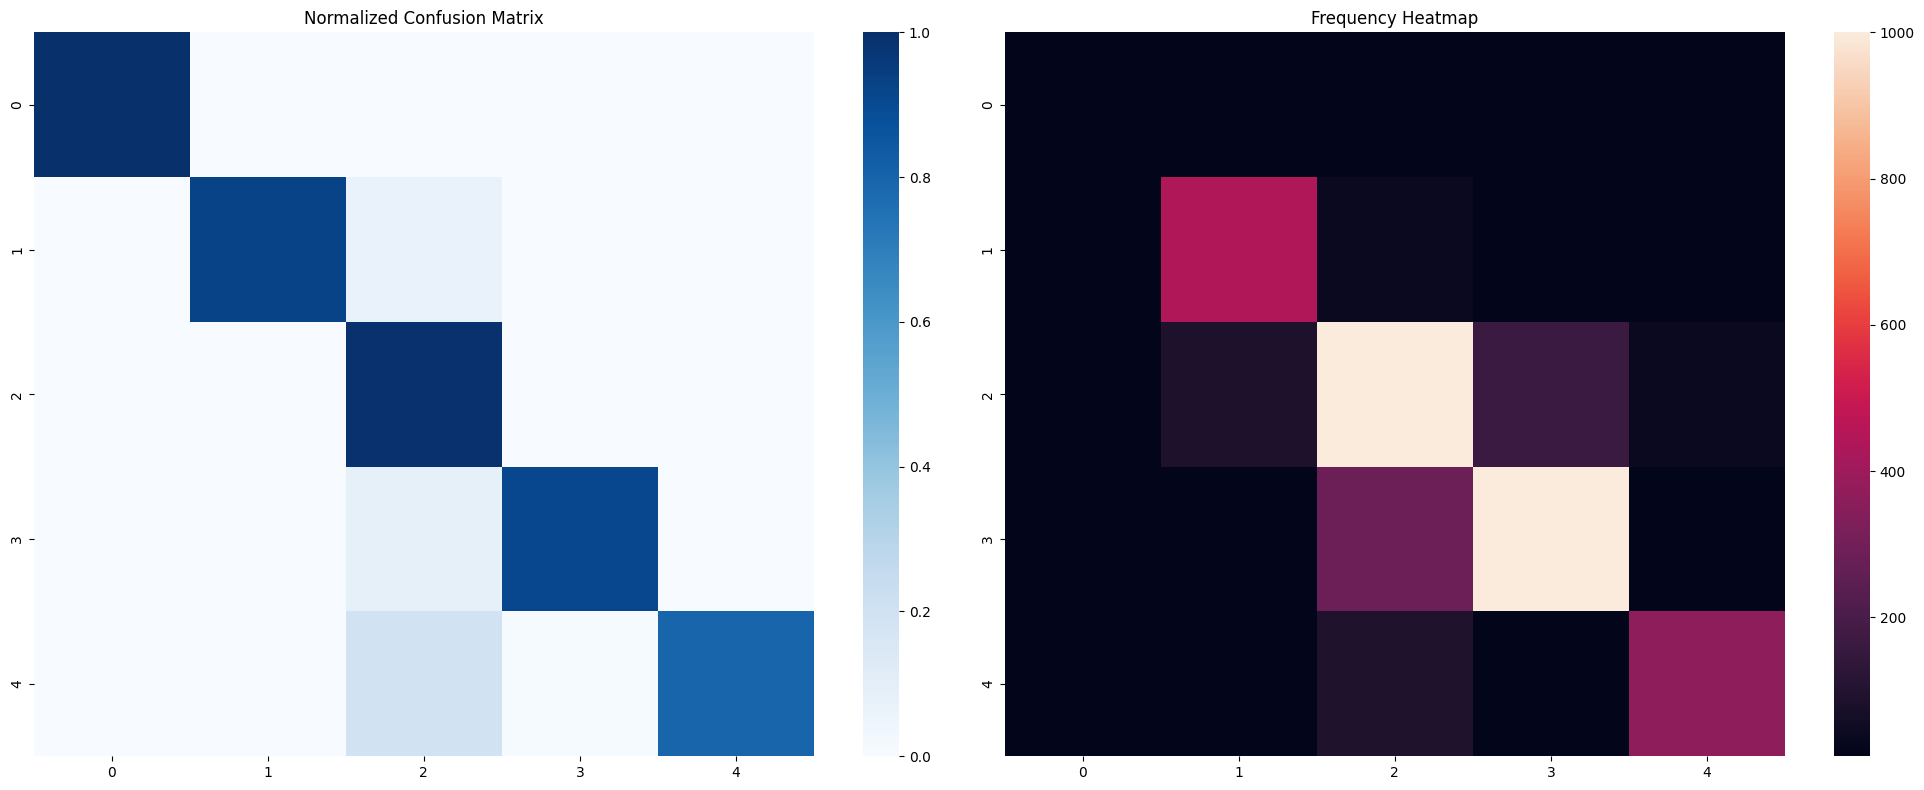

In [65]:
plot_confusion_matrix(bmccb['true_labels'], bmccb['predictions'], n_classes=5)

#### Conformal Prediction

In [68]:
X_calib_21, X_test_21, y_calib_21, y_test_21 = train_test_split(
    X_valid_21, y_valid_21, test_size=0.5, random_state=RANDOM_SEED
)

calib_21_dataset = TextDataset(X_calib_21, y_calib_21, valid_path)
test_21_dataset = TextDataset(X_test_21, y_test_21, valid_path)
calib_21_dataloader = DataLoader(calib_21_dataset, batch_size=16, shuffle=False)
test_21_dataloader = DataLoader(test_21_dataset, batch_size=16, shuffle=False)

In [ ]:
# Calibration
calib_21_probs = []
calib_21_preds = []
calib_21_true = []

model_century_classifier.eval()

with torch.no_grad():
    for text, labels in tqdm(calib_21_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_century_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        calib_21_probs.extend(probabilities.detach().cpu().numpy())
        calib_21_preds.extend(predictions.detach().cpu().numpy())
        calib_21_true.extend(labels.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [25:17<00:00,  1.13it/s]


In [ ]:
# Group calibration data by true class
class_nonconformity_21 = {class_idx: [] for class_idx in range(5)}

# Compute class-specific nonconformity scores
for i, (prob, true_label) in enumerate(zip(calib_21_probs, calib_21_true)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_21[true_label].append(nonconformity)

# Calculate threshold for each class
class_thresholds_21 = {}
confidence_level = 0.90
alpha = 1 - confidence_level

n_samples = len(calib_21_true)
for class_idx, scores in class_nonconformity_21.items():
    q = np.ceil((n_samples + 1) * (1 - alpha)) / n_samples # corrected formula
    class_thresholds_21[class_idx] = np.quantile(scores, q)   

In [ ]:
test_preds_21 = []
test_intervals_21 = []
test_true_21 = []
test_probs_21 = []

with torch.no_grad():
    for text, labels in tqdm(test_21_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_century_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        for i, prob in enumerate(probabilities): # Iterate on the batch
            pred = predictions[i].item()
            true_label = labels[i].item()          
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(5):
                # Use threshold specific to the candidate class
                if 1 - prob[label].item() <= class_thresholds_21[label]:
                    prediction_set.append(label)  
                    
            test_preds_21.append(pred)
            test_intervals_21.append(prediction_set)
            test_true_21.append(true_label)
            test_probs_21.append(prob.detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [25:00<00:00,  1.14it/s]


In [127]:
test_preds_argmax_21 = []
test_preds_argmax_int_21 = []
test_preds_var_21 = []
test_preds_var_rel_21 = []


test_true_var_21 = []
thslds_21 = [ 1 - x for x in class_thresholds_21.values()]

#for idx in range(len(test_probs_21)):
for idx, tidx in enumerate(X_test_21):
    
    tidx = int(tidx.replace('valid_text', '').replace('.txt', ''))
    # if tidx in blacklist_valid:
    #    continue
    
    intervals = test_intervals_21[idx]
    #if len(intervals) != 1:
    #    continue
    true_label = test_true_21[idx]
    probs = test_probs_21[idx]
    
    exeeding_argmax = np.zeros(5)
    exeeding_idx = np.zeros(5)
    exeeding_rel_idx = np.zeros(5)
    
    for interval in intervals:
        if probs[interval] > thslds_21[interval]:
            
            exeeding_argmax[interval] = probs[interval]
            
            exeeding_idx[interval] = abs(probs[interval]-thslds_21[interval])
            
            exeeding_rel_idx[interval] = abs(probs[interval]-thslds_21[interval]) / (1-thslds_21[interval]) #thslds_21[interval] #probs[interval]
            
    test_preds_argmax_21.append(np.argmax(probs))
    test_preds_argmax_int_21.append(np.argmax(exeeding_argmax))
    test_preds_var_21.append(np.argmax(exeeding_idx))
    test_preds_var_rel_21.append(np.argmax(exeeding_rel_idx))
    
    test_true_var_21.append(true_label)
    
print(f"argmax (MAE): {mean_avg_error(np.array(test_true_var_21), np.array(test_preds_argmax_21))}")
print(f"argmax int (MAE): {mean_avg_error(np.array(test_true_var_21), np.array(test_preds_argmax_int_21))}")
print(f"variance (MAE): {mean_avg_error(np.array(test_true_var_21), np.array(test_preds_var_21))}")
print(f"variance rel (MAE): {mean_avg_error(np.array(test_true_var_21), np.array(test_preds_var_rel_21))}")

argmax (MAE): 0.2504574398009222
argmax int (MAE): 0.41023201346702776
variance (MAE): 1.0482324526092366
variance rel (MAE): 1.0225792285735198


In [128]:
table_data = []


# Argmax model
overall_mae_base = mean_avg_error(np.array(test_true_var_21), np.array(test_preds_argmax_21))
class_maes_base = compute_class_mae(test_true_var_21, test_preds_argmax_21)
class_freqs_base = count_class_frequencies(test_true_var_21)
argmax_row = ["argmax", f"{overall_mae_base:.4f} [{len(test_true_var_21)}]"]
for i, mae in enumerate(class_maes_base):
    argmax_row.append(f"{mae:.4f} [{class_freqs_base[i]}]")
table_data.append(argmax_row)

# Argmax int model
overall_mae_base = mean_avg_error(np.array(test_true_var_21), np.array(test_preds_argmax_int_21))
class_maes_base = compute_class_mae(test_true_var_21, test_preds_argmax_int_21)
class_freqs_base = count_class_frequencies(test_true_var_21)
argmax_int_row = ["argmax interval", f"{overall_mae_base:.4f} [{len(test_true_var_21)}]"]
for i, mae in enumerate(class_maes_base):
    argmax_int_row.append(f"{mae:.4f} [{class_freqs_base[i]}]")
table_data.append(argmax_int_row)

# Variance model
overall_mae_base = mean_avg_error(np.array(test_true_var_21), np.array(test_preds_var_21))
class_maes_base = compute_class_mae(test_true_var_21, test_preds_var_21)
class_freqs_base = count_class_frequencies(test_true_var_21)
var_row = ["var", f"{overall_mae_base:.4f} [{len(test_true_var_21)}]"]
for i, mae in enumerate(class_maes_base):
    var_row.append(f"{mae:.4f} [{class_freqs_base[i]}]")
table_data.append(var_row)

# Var rel model
overall_mae_base = mean_avg_error(np.array(test_true_var_21), np.array(test_preds_var_rel_21))
class_maes_base = compute_class_mae(test_true_var_21, test_preds_var_rel_21)
class_freqs_base = count_class_frequencies(test_true_var_21)
var_rel_row = ["var rel", f"{overall_mae_base:.4f} [{len(test_true_var_21)}]"]
for i, mae in enumerate(class_maes_base):
    var_rel_row.append(f"{mae:.4f} [{class_freqs_base[i]}]")
table_data.append(var_rel_row)

print(tabulate(table_data,
               ["Mode", "Overall MAE", "Century 0", "Century 1", "Century 2", "Century 3", "Century 4"], 
               tablefmt="grid"))

+-----------------+----------------+---------------+---------------+----------------+---------------+--------------+
| Mode            | Overall MAE    | Century 0     | Century 1     | Century 2      | Century 3     | Century 4    |
+=================+================+===============+===============+================+===============+==============+
| argmax          | 0.2505 [27326] | 2.0000 [1508] | 1.0000 [1696] | 0.0007 [22243] | 1.0024 [1652] | 2.0264 [227] |
+-----------------+----------------+---------------+---------------+----------------+---------------+--------------+
| argmax interval | 0.4102 [27326] | 1.8130 [1508] | 1.0106 [1696] | 0.1966 [22243] | 1.1429 [1652] | 2.2115 [227] |
+-----------------+----------------+---------------+---------------+----------------+---------------+--------------+
| var             | 1.0482 [27326] | 1.4980 [1508] | 0.8066 [1696] | 0.9855 [22243] | 1.5738 [1652] | 2.1850 [227] |
+-----------------+----------------+---------------+------------

[34] Pred: 2 - True 1
[0, 1, 2, 3]
2


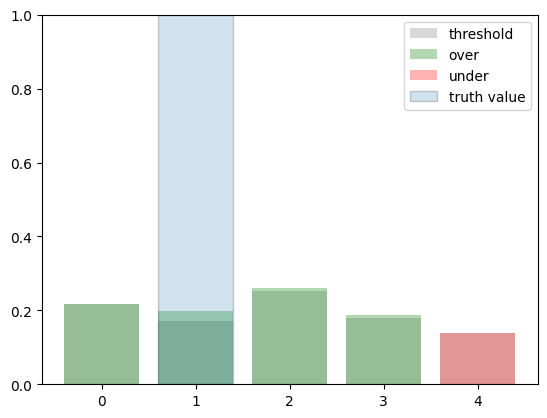

In [129]:
limit = 1
for idx in range(len(test_probs_21)):
    ex_prob = test_probs_21[idx]
    if np.argmax(ex_prob) == test_true_21[idx]:
        continue
        
    #if abs(np.argmax(ex_prob) - test_true_21[idx]) < 5:
    #    continue
        
    print(f"[{idx}] Pred: {np.argmax(ex_prob)} - True {test_true_21[idx]}")
    print(test_intervals_21[idx])
    print(test_preds_21[idx])
    oks = [ x if 1 - x <= y else 0  for x, y in zip(ex_prob, class_thresholds_21.values()) ]
    not_oks = [ x if 1 - x > y else 0  for x, y in zip(ex_prob, class_thresholds_21.values()) ]

    plt.bar(class_thresholds_21.keys(), [ 1 - x for x in class_thresholds_21.values()], color='grey', alpha=0.3, label='threshold')
    #plt.bar(range(43), ex_prob, alpha=0.3)
    plt.bar(range(5), oks, alpha=0.3, color='green', label='over')
    plt.bar(range(5), not_oks, alpha=0.3, color='red', label='under')
    
    gt = np.zeros(5)
    gt[test_true_21[idx]] = 1
    plt.bar(range(5), gt, alpha=0.2, edgecolor='black', label='truth value')
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    
    limit -= 1
    if limit == 0:
        break

## Decade

In [131]:
class DecadeClassifier(nn.Module):
    def __init__(self, century_model, num_decades=10):
        super(DecadeClassifier, self).__init__()
       
        self.bert = century_model.bert
        
        for param in self.bert.parameters():
            param.requires_grad = False
            
        self.dropout = nn.Dropout(0.1)
        
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_decades)
        self.century_to_decade = nn.Linear(5, num_decades)
        
    def forward(self, input_ids, attention_mask, century_logits=None, token_type_ids=None):
        
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        
        
        decade_logits = self.classifier(pooled_output)
        
        if century_logits is not None:
            century_contribution = self.century_to_decade(century_logits)
            decade_logits = decade_logits + century_contribution
            
        return decade_logits

### Evaluation

In [137]:
# Base model

model_century_classifier = CenturyClassifier(model, 5)
model_century_classifier.load_state_dict(torch.load('models/task21/century_classifier_weights_3.pt'))
model_century_classifier.to(device)

model_decade_classifier = DecadeClassifier(model_century_classifier)
model_decade_classifier.load_state_dict(torch.load('models/task22/decade_classifier_weights_3_frozen.pt'))
model_decade_classifier.to(device)

model_century_classifier_blk = CenturyClassifier(model, 5)
model_century_classifier_blk.load_state_dict(torch.load('models/task21/century_classifier_weights_3_blacklist.pt'))
model_century_classifier_blk.to(device)

model_decade_classifier_blk = DecadeClassifier(model_century_classifier_blk)
model_decade_classifier_blk.load_state_dict(torch.load('models/task22/decade_classifier_weights_3_blacklist_frozen.pt'))
model_decade_classifier_blk.to(device)

print('Model loaded!')

Model loaded!


#### Standrard

In [136]:
y_test_pred_22 = []
y_test_true_22 = []

with torch.no_grad():
    for text, labels in tqdm(valid22_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3,).to(device)
        output = model_decade_classifier(**tokens)
        predictions = output.argmax(dim=1)
        y_test_pred_22.extend(predictions.detach().cpu().numpy())
        y_test_true_22.extend(labels.cpu().numpy())
        
print(f"MAE (without CP) [All]: {mean_avg_error(np.array(y_test_true_22), np.array(y_test_pred_22))}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3416/3416 [38:02<00:00,  1.50it/s]

MAE (without CP) [All]: 2.545900349490403


In [138]:
y_test_pred_22_blk = []
y_test_true_22_blk = []

with torch.no_grad():
    for text, labels in tqdm(valid22_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3,).to(device)
        output = model_decade_classifier_blk(**tokens)
        predictions = output.argmax(dim=1)
        y_test_pred_22_blk.extend(predictions.detach().cpu().numpy())
        y_test_true_22_blk.extend(labels.cpu().numpy())
        
print(f"MAE (without CP) [All]: {mean_avg_error(np.array(y_test_true_22_blk), np.array(y_test_pred_22_blk))}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3416/3416 [38:01<00:00,  1.50it/s]

MAE (without CP) [All]: 2.508261513970467


#### Confromal 

In [139]:
X_calib_22, X_test_22, y_calib_22, y_test_22 = train_test_split(
    X_valid_22, y_valid_22, test_size=0.5, random_state=RANDOM_SEED
)

calib_22_dataset = TextDataset(X_calib_22, y_calib_22, valid_path)
test_22_dataset = TextDataset(X_test_22, y_test_22, valid_path)
calib_22_dataloader = DataLoader(calib_22_dataset, batch_size=16, shuffle=False)
test_22_dataloader = DataLoader(test_22_dataset, batch_size=16, shuffle=False)

In [140]:
# Calibration
calib_22_probs = []
calib_22_preds = []
calib_22_true = []

model_decade_classifier.eval()

with torch.no_grad():
    for text, labels in tqdm(calib_22_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        calib_22_probs.extend(probabilities.detach().cpu().numpy())
        calib_22_preds.extend(predictions.detach().cpu().numpy())
        calib_22_true.extend(labels.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [18:53<00:00,  1.51it/s]


In [142]:
# Group calibration data by true class
class_nonconformity_22 = {class_idx: [] for class_idx in range(10)}

# Compute class-specific nonconformity scores
for i, (prob, true_label) in enumerate(zip(calib_22_probs, calib_22_true)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_22[true_label].append(nonconformity)

# Calculate threshold for each class
class_thresholds_22 = {}
confidence_level = 0.90
alpha = 1 - confidence_level

n_samples = len(calib_22_true)
for class_idx, scores in class_nonconformity_22.items():
    q = np.ceil((n_samples + 1) * (1 - alpha)) / n_samples # corrected formula
    class_thresholds_22[class_idx] = np.quantile(scores, q)   

In [143]:
test_preds_22 = []
test_intervals_22 = []
test_true_22 = []
test_probs_22 = []

with torch.no_grad():
    for text, labels in tqdm(test_22_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        for i, prob in enumerate(probabilities): # Iterate on the batch
            pred = predictions[i].item()
            true_label = labels[i].item()          
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(10):
                # Use threshold specific to the candidate class
                if 1 - prob[label].item() <= class_thresholds_22[label]:
                    prediction_set.append(label)  
                    
            test_preds_22.append(pred)
            test_intervals_22.append(prediction_set)
            test_true_22.append(true_label)
            test_probs_22.append(prob.detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [18:57<00:00,  1.50it/s]


In [144]:
test_preds_argmax_22 = []
test_preds_argmax_int_22 = []
test_preds_var_22 = []
test_preds_var_rel_22 = []


test_true_var_22 = []
thslds_22 = [ 1 - x for x in class_thresholds_22.values()]

#for idx in range(len(test_probs_21)):
for idx, tidx in enumerate(X_test_22):
    
    tidx = int(tidx.replace('valid_text', '').replace('.txt', ''))
    # if tidx in blacklist_valid:
    #    continue
    
    intervals = test_intervals_22[idx]
    #if len(intervals) != 1:
    #    continue
    true_label = test_true_22[idx]
    probs = test_probs_22[idx]
    
    exeeding_argmax = np.zeros(10)
    exeeding_idx = np.zeros(10)
    exeeding_rel_idx = np.zeros(10)
    
    for interval in intervals:
        if probs[interval] > thslds_22[interval]:
            
            exeeding_argmax[interval] = probs[interval]
            
            exeeding_idx[interval] = abs(probs[interval]-thslds_22[interval])
            
            exeeding_rel_idx[interval] = abs(probs[interval]-thslds_22[interval]) / (1-thslds_22[interval]) #thslds_21[interval] #probs[interval]
            
    test_preds_argmax_22.append(np.argmax(probs))
    test_preds_argmax_int_22.append(np.argmax(exeeding_argmax))
    test_preds_var_22.append(np.argmax(exeeding_idx))
    test_preds_var_rel_22.append(np.argmax(exeeding_rel_idx))
    
    test_true_var_22.append(true_label)
    
print(f"argmax (MAE): {mean_avg_error(np.array(test_true_var_22), np.array(test_preds_argmax_22))}")
print(f"argmax int (MAE): {mean_avg_error(np.array(test_true_var_22), np.array(test_preds_argmax_int_22))}")
print(f"variance (MAE): {mean_avg_error(np.array(test_true_var_22), np.array(test_preds_var_22))}")
print(f"variance rel (MAE): {mean_avg_error(np.array(test_true_var_22), np.array(test_preds_var_rel_22))}")

argmax (MAE): 2.56367562028837
argmax int (MAE): 2.53004464612457
variance (MAE): 2.703944960843153
variance rel (MAE): 2.696735709580619


In [154]:
table_data = []


# Argmax model
overall_mae_base = mean_avg_error(np.array(test_true_var_22), np.array(test_preds_argmax_22))
class_maes_base = compute_class_mae(test_true_var_22, test_preds_argmax_22, n_classes=10)
class_freqs_base = count_class_frequencies(test_true_var_22, n_classes=10)
argmax_row = ["argmax", f"{overall_mae_base:.3f} [{len(test_true_var_22)}]"]
for i, mae in enumerate(class_maes_base):
    # argmax_row.append(f"{mae:.3f} [{class_freqs_base[i]}]")
    argmax_row.append(f"{mae:.3f}")
    
table_data.append(argmax_row)

# Argmax int model
overall_mae_base = mean_avg_error(np.array(test_true_var_22), np.array(test_preds_argmax_int_22))
class_maes_base = compute_class_mae(test_true_var_22, test_preds_argmax_int_22, n_classes=10)
class_freqs_base = count_class_frequencies(test_true_var_22, n_classes=10)
argmax_int_row = ["[CP] argmax", f"{overall_mae_base:.3f} [{len(test_true_var_22)}]"]
for i, mae in enumerate(class_maes_base):
    # argmax_int_row.append(f"{mae:.3f} [{class_freqs_base[i]}]")
    argmax_int_row.append(f"{mae:.3f}")
table_data.append(argmax_int_row)

# Variance model
overall_mae_base = mean_avg_error(np.array(test_true_var_22), np.array(test_preds_var_22))
class_maes_base = compute_class_mae(test_true_var_22, test_preds_var_22, n_classes=10)
class_freqs_base = count_class_frequencies(test_true_var_22, n_classes=10)
var_row = ["[CP] var", f"{overall_mae_base:.3f} [{len(test_true_var_22)}]"]
for i, mae in enumerate(class_maes_base):
    # var_row.append(f"{mae:.3f} [{class_freqs_base[i]}]")
    var_row.append(f"{mae:.3f}")
table_data.append(var_row)

# Var rel model
overall_mae_base = mean_avg_error(np.array(test_true_var_22), np.array(test_preds_var_rel_22))
class_maes_base = compute_class_mae(test_true_var_22, test_preds_var_rel_22, n_classes=10)
class_freqs_base = count_class_frequencies(test_true_var_22, n_classes=10)
var_rel_row = ["[CP] var rel", f"{overall_mae_base:.3f} [{len(test_true_var_22)}]"]
for i, mae in enumerate(class_maes_base):
    # var_rel_row.append(f"{mae:.3f} [{class_freqs_base[i]}]")
    var_rel_row.append(f"{mae:.3f}")

table_data.append(var_rel_row)

print(tabulate(table_data,
               ["Mode", "Overall MAE", "Decade 0", "Decade 1", "Decade 2", "Decade 3", "Decade 4", "Decade 5"
               , "Decade 6", "Decade 7", "Decade 8", "Decade 9"], 
               tablefmt="grid"))

+--------------+---------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
| Mode         | Overall MAE   |   Decade 0 |   Decade 1 |   Decade 2 |   Decade 3 |   Decade 4 |   Decade 5 |   Decade 6 |   Decade 7 |   Decade 8 |   Decade 9 |
+==============+===============+============+============+============+============+============+============+============+============+============+============+
| argmax       | 2.564 [27326] |      7.451 |      6.693 |      5.97  |      5.035 |      4.046 |      2.996 |      2.083 |      1.151 |      0.337 |      1.134 |
+--------------+---------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
| [CP] argmax  | 2.530 [27326] |      7.195 |      6.416 |      5.847 |      5.014 |      4.035 |      2.984 |      2.085 |      1.155 |      0.345 |      1.147 |
+--------------+------